In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sdv.tabular import CopulaGAN
from sdv.evaluation import evaluate
from sdv.constraints import UniqueCombinations, GreaterThan


import os, glob

In [34]:
def plot_corr(data, figsize=(15,15)):
    '''
    Plot correlation 
    Args:
    - data: pd dataframe
    '''
    corr = data.corr()
    sns.set(font_scale=1.2)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(corr, mask=mask, square=True, 
                         vmin= -1, vmax=1,
                         cmap='RdBu_r', center=0, annot=True,
                        annot_kws={'fontsize':8})

In [39]:
data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), '../Data/Merged_data/Survival_df.csv'),
                    index_col=0)

In [40]:
data.NDE_cycle = data.NDE_cycle.astype('str')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16 entries, 41C to 49C
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Observed              16 non-null     bool   
 1   F_Time                16 non-null     float64
 2   NDE_cyle              16 non-null     object 
 3   diff_two_peaks_ratio  16 non-null     float64
 4   amp_ratio             16 non-null     float64
 5   pos_ratio             16 non-null     float64
 6   energy_ratio          16 non-null     float64
 7   NLE_ratio_51_17       16 non-null     float64
 8   NLE_ratio_85_17       16 non-null     float64
 9   NLE_ratio_119_17      16 non-null     float64
 10  NLO_avg               16 non-null     float64
 11  Avg_RP                16 non-null     float64
 12  ACEE_30_Avg_58        16 non-null     float64
 13  ACEE_500_Avg_58       16 non-null     float64
 14  ACPD_Avg_58           16 non-null     float64
dtypes: bool(1), float64(13), ob

# CopulaGAN

The sdv.tabular.CopulaGAN model is a variation of the CTGAN Model which takes advantage of the CDF based transformation that the GaussianCopulas apply to make the underlying CTGAN model task of learning the data easier.

# Model the data

## tuning distribution and fitting model

In [22]:
model = CopulaGAN(
    epochs=5000,
    #constraints=constraints,
#     field_distributions={
#         'KJIC':'gaussian_kde',
#     }
)

In [23]:
model.fit(data)

/home/marie-anne/anaconda3/envs/EPRI/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/marie-anne/anaconda3/envs/EPRI/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/marie-anne/anaconda3/envs/EPRI/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:4965: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)
/home/marie-anne/anaconda3/envs/EPRI/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/home/marie-anne/anaconda3/envs/EPRI/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass n_components=10 as keywo

In [24]:
model.get_distributions()

{'Observed': 'copulas.univariate.gaussian.GaussianUnivariate',
 'F_Time': 'copulas.univariate.beta.BetaUnivariate',
 'diff_two_peaks_ratio': 'copulas.univariate.log_laplace.LogLaplace',
 'amp_ratio': 'copulas.univariate.log_laplace.LogLaplace',
 'pos_ratio': 'copulas.univariate.gamma.GammaUnivariate',
 'energy_ratio': 'copulas.univariate.log_laplace.LogLaplace',
 'NLE_ratio_51_17': 'copulas.univariate.log_laplace.LogLaplace',
 'NLE_ratio_85_17': 'copulas.univariate.student_t.StudentTUnivariate',
 'NLE_ratio_119_17': 'copulas.univariate.student_t.StudentTUnivariate',
 'NLO_avg': 'copulas.univariate.truncated_gaussian.TruncatedGaussian',
 'Avg_RP': 'copulas.univariate.gamma.GammaUnivariate',
 'ACEE_30_Avg_58': 'copulas.univariate.student_t.StudentTUnivariate',
 'ACEE_500_Avg_58': 'copulas.univariate.log_laplace.LogLaplace',
 'ACPD_Avg_58': 'copulas.univariate.gamma.GammaUnivariate'}

# Generate synthetic data

In [25]:
samples = model.sample(1000)

In [26]:
samples.head()

,Observed,F_Time,NDE_cyle,diff_two_peaks_ratio,amp_ratio,pos_ratio,energy_ratio,NLE_ratio_51_17,NLE_ratio_85_17,NLE_ratio_119_17,NLO_avg,Avg_RP,ACEE_30_Avg_58,ACEE_500_Avg_58,ACPD_Avg_58
0,False,1.751191e+06,600000,0.529909,1.091504,0.993960,0.848464,0.917375,1.112056,0.505540,5.432829,174.266786,-0.847639,-1.340496,3.276437
1,False,8.805501e+05,750000,0.196585,0.849821,0.994489,0.505600,0.910996,1.116821,0.497770,6.898934,171.325300,-0.893297,-1.712179,3.106521
2,True,3.848121e+05,900000,0.384845,1.077153,1.000971,0.708655,0.878908,1.130553,0.487624,3.948716,170.217690,-0.764145,-1.190668,2.559568
3,True,1.194672e+06,0,2.474125,1.338242,0.995126,1.308626,0.895148,1.132818,0.487866,6.884989,188.904421,-0.476904,-2.805754,4.676679
4,True,7.445108e+05,900000,0.437564,1.039553,1.007743,0.721039,0.894121,1.163510,0.495600,5.466000,171.473636,-0.947583,-1.325563,2.553673


In [27]:
samples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Observed              1000 non-null   bool   
 1   F_Time                1000 non-null   float64
 2   NDE_cyle              1000 non-null   object 
 3   diff_two_peaks_ratio  1000 non-null   float64
 4   amp_ratio             1000 non-null   float64
 5   pos_ratio             1000 non-null   float64
 6   energy_ratio          1000 non-null   float64
 7   NLE_ratio_51_17       1000 non-null   float64
 8   NLE_ratio_85_17       1000 non-null   float64
 9   NLE_ratio_119_17      1000 non-null   float64
 10  NLO_avg               1000 non-null   float64
 11  Avg_RP                1000 non-null   float64
 12  ACEE_30_Avg_58        1000 non-null   float64
 13  ACEE_500_Avg_58       1000 non-null   float64
 14  ACPD_Avg_58           1000 non-null   float64
dtypes: bool(1), float64(13

### Evaluate

The output of this function call will be a number between 0 and 1 that will indicate us how similar the two tables are, being 0 the worst and 1 the best possible score.

The evaluate function applies a collection of pre-configured metric functions and returns the average of the scores that the data obtained on each one of them. To explore the metrics in more detail, you can pass and additional argument aggregate=False.


- cstest: This metric compares the distributions of all the categorical columns of the table by using a Chi-squared test and returns the average of the p-values obtained across all the columns. If the tables that you are evaluating do not contain any categorical columns the result will be nan.

- kstest: This metric compares the distributions of all the numerical columns of the table with a two-sample Kolmogorov–Smirnov test using the empirical CDF and returns the average of the p-values obtained across all the columns. If the tables that you are evaluating do not contain any numerical columns the result will be nan.

- logistic_detection: This metric tries to use a Logistic Regression classifier to detect whether each row is real or synthetic and then evaluates its performance using an Area under the ROC curve metric. The returned score is 1 minus the ROC AUC score obtained by the classifier.

- svc_detection: This metric tries to use an Support Vector Classifier to detect whether each row is real or synthetic and then evaluates its performance using an Area under the ROC curve metric. The returned score is 1 minus the ROC AUC score obtained by the classifier.


In [28]:
evaluate(samples, data)

0.6681341197610337

In [29]:
evaluate(samples, data, aggregate = False)

{'cstest': 0.9888308015385688,
 'kstest': 0.5935023004758413,
 'logistic_detection': 0.5619921318524113,
 'svc_detection': 0.5347784910659162}

In [30]:
data.describe()

,F_Time,diff_two_peaks_ratio,amp_ratio,pos_ratio,energy_ratio,NLE_ratio_51_17,NLE_ratio_85_17,NLE_ratio_119_17,NLO_avg,Avg_RP,ACEE_30_Avg_58,ACEE_500_Avg_58,ACPD_Avg_58
count,1.600000e+01,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,1.417697e+06,0.788127,1.031994,0.998382,0.934331,0.899475,1.121816,0.484558,5.156680,175.298605,-0.818316,-1.670322,3.403606
std,9.653615e+05,0.610000,0.203137,0.008879,0.312578,0.028879,0.042745,0.021237,1.405015,7.172232,0.267701,0.675367,0.660872
min,2.000070e+05,0.144147,0.656073,0.982972,0.394731,0.844824,1.037133,0.432253,3.061693,169.717689,-1.276355,-3.202220,2.375193
25%,5.022565e+05,0.432558,0.892097,0.991597,0.785142,0.887572,1.097819,0.477415,4.171880,170.846385,-0.926859,-1.696258,2.890848
50%,1.381439e+06,0.630974,1.090540,1.000778,0.849441,0.893242,1.117198,0.488176,4.925884,172.326261,-0.862900,-1.467427,3.255522
75%,2.146388e+06,0.833150,1.180048,1.003030,1.130465,0.913813,1.139100,0.494032,6.210666,174.994399,-0.661134,-1.262696,3.876800
max,3.245267e+06,2.280959,1.365329,1.015363,1.559453,0.978877,1.235508,0.530102,7.862192,190.979294,-0.137640,-0.927155,4.804749


In [31]:
samples.describe()

,F_Time,diff_two_peaks_ratio,amp_ratio,pos_ratio,energy_ratio,NLE_ratio_51_17,NLE_ratio_85_17,NLE_ratio_119_17,NLO_avg,Avg_RP,ACEE_30_Avg_58,ACEE_500_Avg_58,ACPD_Avg_58
count,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.244507e+06,1.133005,1.131134,0.997299,0.947360,0.893824,1.118086,0.487002,4.978121,176.036160,-0.742064,-1.476144,3.289444
std,9.479983e+05,1.549720,0.168585,0.006868,0.405058,0.029579,0.042516,0.044601,1.273407,8.595503,0.260080,0.443861,0.646675
min,2.000070e+05,0.141545,0.646568,0.976116,0.394296,0.765045,0.921093,-0.120895,3.061693,169.717689,-1.441564,-3.567825,2.206456
25%,3.753348e+05,0.417305,1.016228,0.992722,0.700003,0.883684,1.096086,0.481296,3.931082,170.702733,-0.907554,-1.541781,2.830764
50%,1.007960e+06,0.592607,1.111909,0.997053,0.817461,0.894495,1.116600,0.489876,4.900503,172.122706,-0.803696,-1.348315,3.135065
75%,1.942513e+06,0.975712,1.257904,1.001627,1.034012,0.904876,1.136474,0.497644,5.963014,176.532977,-0.634124,-1.225226,3.584000
max,3.245267e+06,19.571014,1.616405,1.018751,3.094952,1.043425,1.369761,0.796520,7.862192,209.257964,0.174506,-0.606396,5.592953


In [47]:
samples.to_csv(os.path.join(os.path.dirname(os.getcwd()), '../Data/Merged_data/CopulaGAN_simulated_data_survival.csv'), index=False)

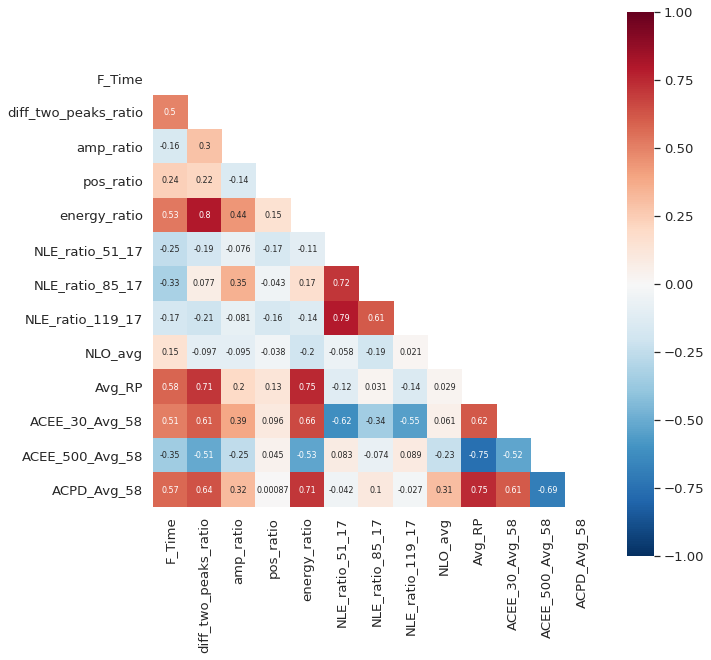

In [38]:
plot_corr(samples.drop('Observed', axis=1), figsize=(10,10))

In [43]:
samples

,Observed,F_Time,NDE_cyle,diff_two_peaks_ratio,amp_ratio,pos_ratio,energy_ratio,NLE_ratio_51_17,NLE_ratio_85_17,NLE_ratio_119_17,NLO_avg,Avg_RP,ACEE_30_Avg_58,ACEE_500_Avg_58,ACPD_Avg_58
0,False,1.751191e+06,600000,0.529909,1.091504,0.993960,0.848464,0.917375,1.112056,0.505540,5.432829,174.266786,-0.847639,-1.340496,3.276437
1,False,8.805501e+05,750000,0.196585,0.849821,0.994489,0.505600,0.910996,1.116821,0.497770,6.898934,171.325300,-0.893297,-1.712179,3.106521
2,True,3.848121e+05,900000,0.384845,1.077153,1.000971,0.708655,0.878908,1.130553,0.487624,3.948716,170.217690,-0.764145,-1.190668,2.559568
3,True,1.194672e+06,0,2.474125,1.338242,0.995126,1.308626,0.895148,1.132818,0.487866,6.884989,188.904421,-0.476904,-2.805754,4.676679
4,True,7.445108e+05,900000,0.437564,1.039553,1.007743,0.721039,0.894121,1.163510,0.495600,5.466000,171.473636,-0.947583,-1.325563,2.553673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,False,3.035034e+06,0,3.131660,1.327767,1.006446,2.672155,0.870106,1.126553,0.461652,5.341247,198.007746,-0.318230,-2.101181,4.278491
996,True,6.093648e+05,900000,0.312099,1.255932,0.997464,0.679803,0.887969,1.112964,0.491979,4.663054,171.740833,-0.806248,-1.186281,2.851250
997,True,3.989339e+05,900000,0.595612,1.167238,1.000232,0.856687,0.891326,1.148279,0.491675,4.363576,172.275905,-0.880523,-1.327719,3.104035
998,True,3.731964e+05,450000,1.486775,1.269441,0.996086,1.009475,0.912585,1.178257,0.488794,4.098630,170.058396,-0.918933,-1.237451,3.339072


In [45]:
samples.NDE_cyle.value_counts()

900000    251
750000    242
600000    197
0         176
450000    134
Name: NDE_cyle, dtype: int64

In [44]:
sns.pairplot(samples.drop('Observed', axis=1), hue='F_Time')

/home/marie-anne/anaconda3/envs/EPRI/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/marie-anne/anaconda3/envs/EPRI/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/marie-anne/anaconda3/envs/EPRI/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/marie-anne/anaconda3/envs/EPRI/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/marie-anne/anaconda3/envs/EPRI/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.war

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f5a7c8ad160> (for post_execute):


KeyboardInterrupt: 

# 4. Save and load the synthesizer

To save a trained ctgan synthesizer, use

`model.save('my_model.pkl')`

To restore a saved synthesizer, use

`loaded = CopulaGAN.load('my_model.pkl')`

`new_data = loaded.sample(200)`

In [46]:
model.save('CopulaGAN_survival.pkl')